# Introduction

This notebook contains an analysis of the simulation `Confinement`. A species is is diffusing freely ($D$ = 0.1 $\mu$m$^2/$s) in an absorbing corral (radius 25 $\mu$m). A few molecules are trapped in much smaller cages (radius 500 nm). 

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.functions import TE_MSD,Michalet,set_size,pool_data
from sklearn.cluster import KMeans
import matplotlib as mpl
import seaborn as sns
import random

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=12
maxframe=100000
rsquared_threshold=-1000

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [2]:
#Preprocess the Smoldyn exact trajectories
data = pd.read_csv('Confinement/output.txt', sep=" ", header=None)
data.columns = ["iteration", "useless1", "useless2", "POSITION_X","POSITION_Y","TRACK_ID"]
data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Confinement/temp.csv',index=None)

In [3]:
files = ["Confinement/temp.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option="thirty_percent",display_id=True)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  12 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  thirty_percent
Reading filenames in  ['Confinement/temp.csv'] ...
Analysis for Confinement/temp.csv ...
Track 0 out of 88
Track 1 out of 88
Track 2 out of 88
Track 3 out of 88
Track 4 out of 88
Track 5 out of 88
Track 6 out of 88
Track 7 out of 88
Track 8 out of 88
Track 9 out of 88
Track 10 out of 88
Track 11 out of 88
Track 12 out of 88
Track 13 out of 88
Track 14 out of 88
Track 15 out of 88
Track 16 out of 88
Track 17 out of 88
Track 18 out of 88
Track 19 out of 88
Track 20 out of 88
Track 21 out of 88
Track 22 out of 88
Track 23 out of 88
Track 24 out of 88
Track 25 out of 88
Track 26 out of 88
Track 27 out of 88
Track 28 out of 88
Track 29 out of 88
Track 30 out of 88
Track 31 out of 88
Track 32 out of 88
Track 33 out of 88
Track 34 out of 88
Track 35 out of 88
Track 36 out of 88
Track 37 out of 88
Track 38 out of 88
Track 39 out of 88
Track 40 out

# Gaussian mixture to identify clusters

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=3,max_iter=5000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=1000)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1,2]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_confined = D_per_group.index(min(D_per_group))
index_free = list(filter(lambda x : x != index_confined, index)) #careful, two different indexes

# MSDs with cluster label

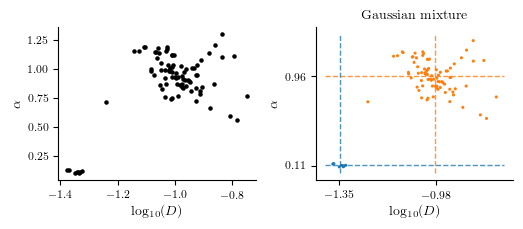

In [5]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_confined else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_confined)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_free[0]) | (df['GM_Label']==index_free[1])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_confined)].mean()
meanD0 = df['D'][(df['GM_Label']==index_free[0]) | (df['GM_Label']==index_free[1])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Confinement/Plots/confinement_exact_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

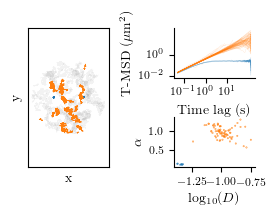

In [6]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(15))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Confinement/Plots/confinement_exact_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


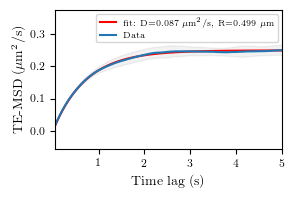

In [7]:
MSDconfined = list(df['MSD'][(df['GM_Label']==index_confined)].values)
temsd,var,timelag = TE_MSD(MSDconfined,plot=False)

from scipy.optimize import curve_fit

def confinement_model(timelag, D, rad):
    return(rad**2*(1-np.exp(-4*D*timelag/rad**2)))

popt, pcov = curve_fit(confinement_model, timelag, temsd)


mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, confinement_model(timelag, *popt), 'r-',label=r'fit: D=%5.3f $\mu$m$^2/$s, R=%5.3f $\mu$m' % tuple(popt))
ax.plot(timelag,temsd,label='Data')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
ax.set_xlim(0.05,5)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
fig.savefig('Confinement/Plots/confinement_exact_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Simulated movie

In [8]:
minframe=8
files = ["Confinement/movie/tracks.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[1,4])

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  8 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  [1, 4]
Reading filenames in  ['Confinement/movie/tracks.csv'] ...
Analysis for Confinement/movie/tracks.csv ...
767  tracks were kept out of  27870 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


# Select sample size 

You should take count as sample size.

In [9]:
display(df.describe())
N = 767
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,767.000000,767.000000,767.000000,767.000000,767.000000
mean,0.564652,-1.198260,0.228808,0.205452,9.581486
std,0.439641,0.486725,0.135759,0.921411,2.387045
min,0.100000,-2.501438,0.005169,-8.752347,8.000000
25%,0.100000,-1.580779,0.128614,-0.136623,8.000000
50%,0.487611,-1.278684,0.210703,0.404585,9.000000
75%,0.877051,-0.850189,0.300747,0.869439,10.000000
max,1.790595,0.000000,0.798664,0.999570,32.000000


# Test the influence of MinFrame and $R^2$

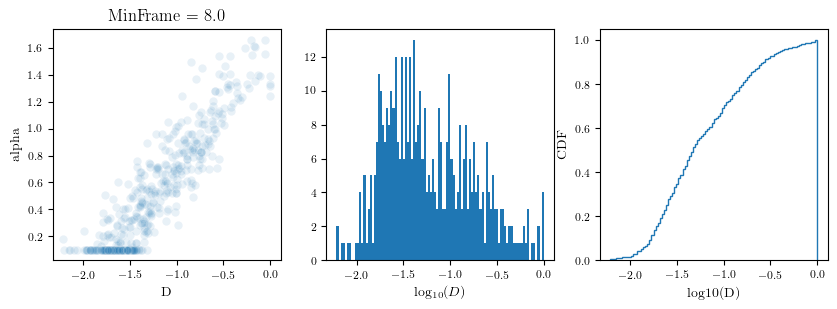

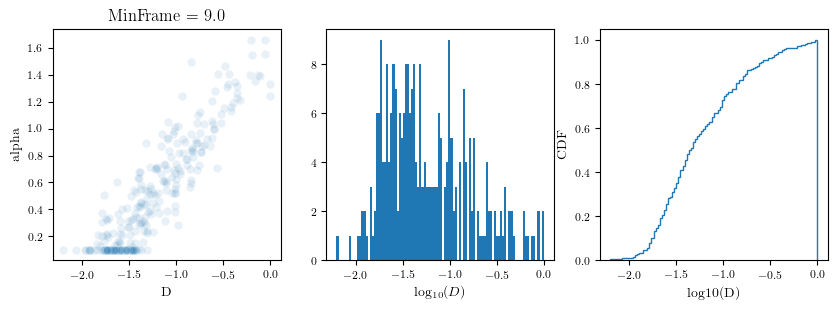

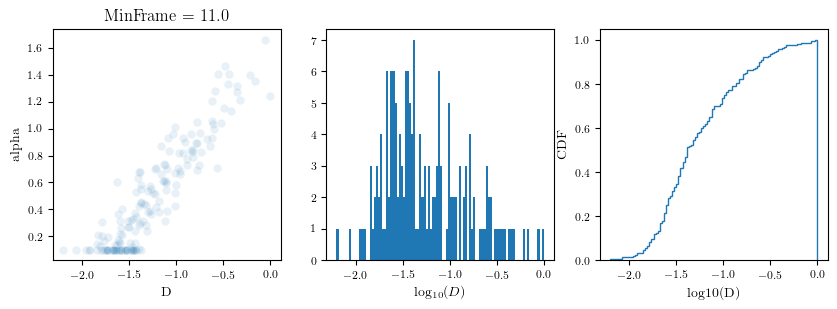

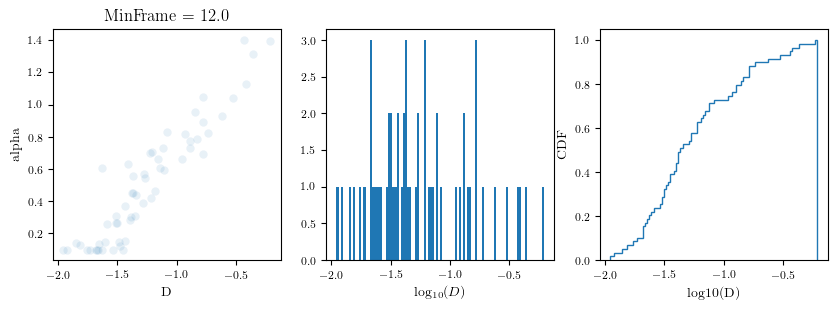

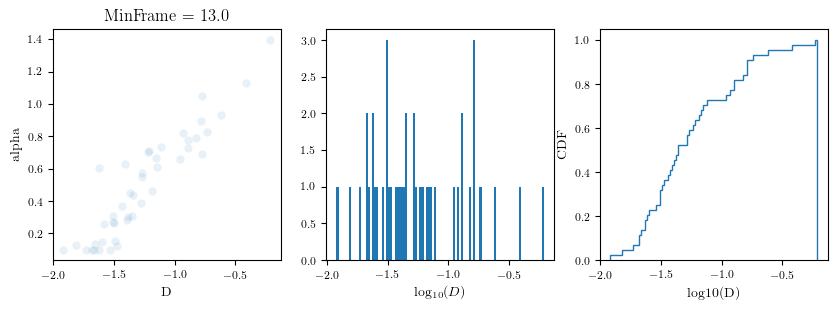

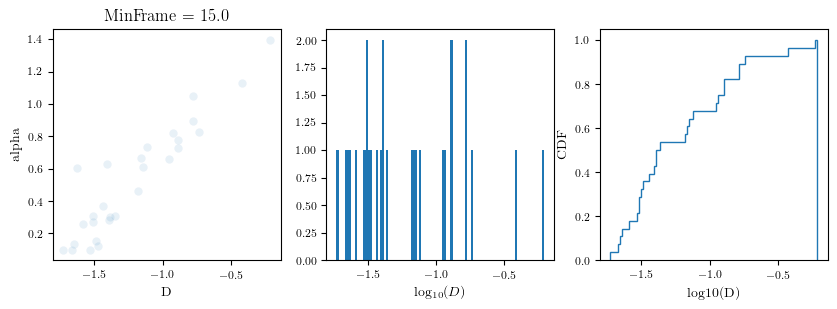

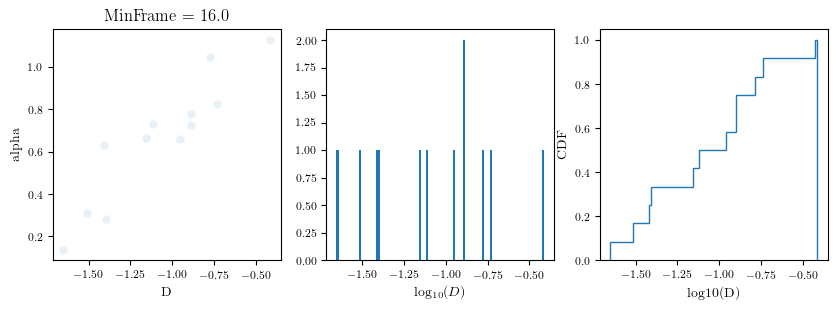

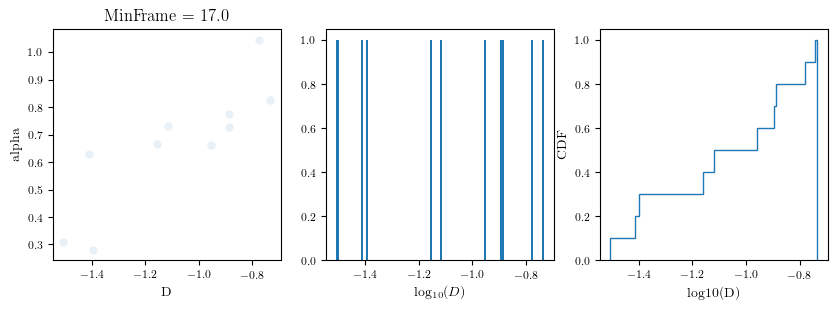

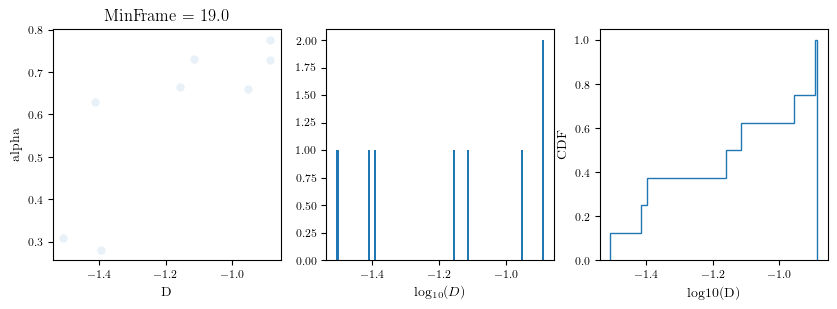

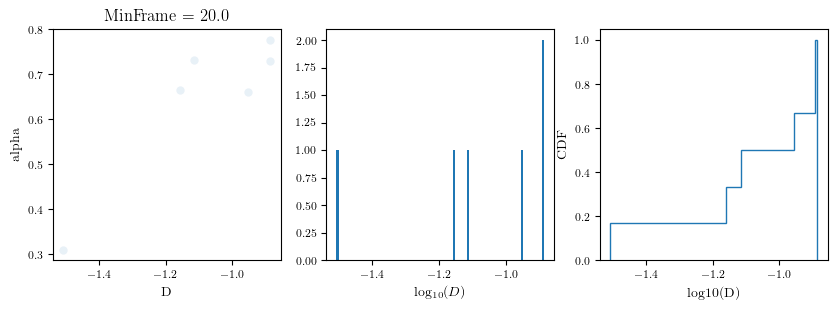

In [10]:
N = np.linspace(minframe,20,10)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>-100)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

# Set Minframe, $R^2$ and apply a Gaussian mixture on the resulting dataset

In [11]:
minframe = 13
r2 = -100
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=1000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=500)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_confined = D_per_group.index(min(D_per_group))
index_free = list(filter(lambda x : x != index_confined, index)) #careful, two different indexes

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


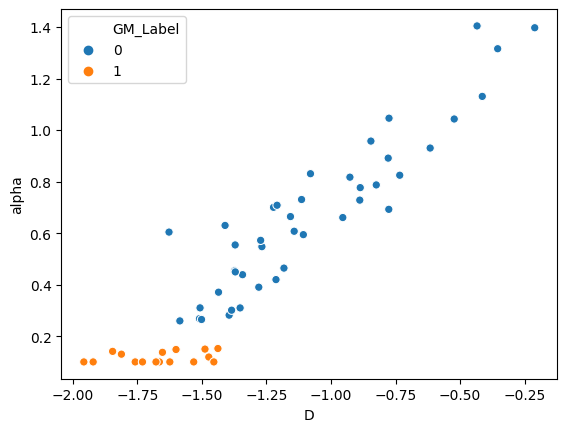

In [12]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.scatterplot(x='D',y='alpha',hue='GM_Label',data=df)
plt.show()

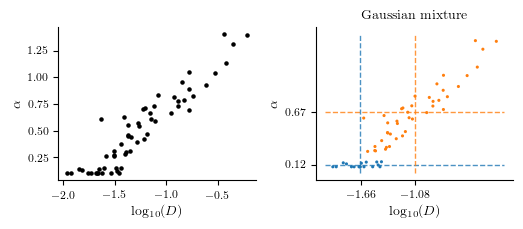

In [13]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_confined else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_confined)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_free[0])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_confined)].mean()
meanD0 = df['D'][(df['GM_Label']==index_free[0])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Confinement/Plots/confinement_movie_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Use the GM-determined labels to visualize trajectories and MSDs

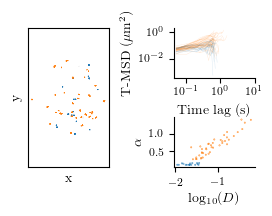

In [14]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(200))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Confinement/Plots/confinement_movie_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Perform specific analysis on the believed to be confined trajectories

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


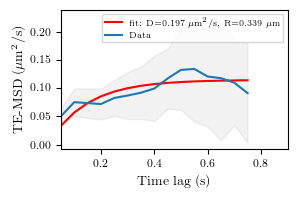

In [15]:
MSDconfined = list(df['MSD'][(df['GM_Label']==index_confined)].values)
temsd,var,timelag = TE_MSD(MSDconfined,plot=False)

from scipy.optimize import curve_fit

def confinement_model(timelag, D, rad):
    return(rad**2*(1-np.exp(-4*D*timelag/rad**2)))

popt, pcov = curve_fit(confinement_model, timelag, temsd)


mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, confinement_model(timelag, *popt), 'r-',label=r'fit: D=%5.3f $\mu$m$^2/$s, R=%5.3f $\mu$m' % tuple(popt))
ax.plot(timelag,temsd,label='Data')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
ax.set_xlim(0.05,0.9)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
fig.savefig('Confinement/Plots/confinement_movie_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()